# Personalized Marketing Campaign Content Creation

#### Image:Data Science 3.0, Kernel: Python3, Isntace: ml.t3.medium 2vCPU + 4GiB
## Use case

Assuming you are a marketing campaign manager, you're going to promote the flight ticket for Airline. At first, AI system will help you find out the target users segment; and then generate marketing promotion template for thoes target users. 
There has two AI engines
1. Recommendation engine - Amazon Personalize service
2. Content Generative engine - Amazon Bedrock service


The pipeline - 

Marketing request-->Personalize-->retrive medata-->combine with PromptTemplate--> Langchain-->Amazon Bedrock & LLM--> Generate content -->save in JSON

## Introduction

In this notebook we show how to generate personalized marketing campaign promotion for email, by contextual metadata and question template. 

LangChain is a framework for developing applications powered by language models. The key aspects of this framework allow us to augment the Large Language Models by chaining together various components to create advanced use cases.

In this notebook we will use the Bedrock API provided by LangChain. The prompt used in this example creates a custom LangChain prompt template for adding context to the text generation request. 


LangChain is a framework for developing applications powered by language models. The key aspects of this framework allow us to augment the Large Models and enable us to perform tasks which meet desired goals and unlock various use-cases.



#### Pre-requisites
Before we get started with the implementation we have to make sure that the required latest boto3 and botocore packages are installed. These will be used to leverage the Amazon Bedrock API client.

Additionally we would need langchain one of  the latest versions, which has Amazon Bedrock class implemented under llms module. Also we are installing the transformers framework from HuggingFace, which we will use to quickly count the number of tokens in the input prompt.

In [ ]:
%pip install --upgrade pip
%pip install boto3 --upgrade
%pip install botocore --upgrade

### Install langchain and transformers

In [ ]:
%pip install langchain
%pip install transformers

In [ ]:
%pip install langchain --upgrade
%pip install transformers --upgrade

In [ ]:
import boto3
import botocore
import transformers

# Get the Boto3 version
boto3_version = boto3.__version__

# Get the Botocore version
botocore_version = botocore.__version__

# Get the Transformers version
transformers_version = transformers.__version__

# Print the Boto3 version
print("Current Boto3 Version:", boto3_version)

# Print the Botocore version
print("Current Botocore Version:", botocore_version)

# Print the Transformers version
print("Transformers Version:", transformers_version)

In [ ]:
%pip show langchain

### Import all libraries

In [7]:
import boto3
import json
import ipywidgets as widgets
from IPython.display import display
from langchain import PromptTemplate

import os
import sys

import time
from tqdm import tqdm

boto3_bedrock  = None


## Prepare Content generative engine, invoke the Bedrock LLM Model

for more details for the parameters please refer to the bedrock api page

In [8]:
bedrock = boto3.client(
 service_name='bedrock',
 region_name='us-east-1',
 endpoint_url='https://bedrock.us-east-1.amazonaws.com'
)

### List all supported FM of Bedrock

In [ ]:
bedrock.list_foundation_models()

### Here, we choose Anthropic model "anthropic.claude-instant-v1". 
It's a faster and cheaper yet still very capable model, which can handle a range of tasks including casual dialogue, text analysis, summarization, and document question-answering.
For more details, please refer https://aws.amazon.com/bedrock/stable-diffusion/

In [10]:
from langchain.llms.bedrock import Bedrock

inference_modifier = {'max_tokens_to_sample':4096, 
                      "temperature":0.7,
                      "top_k":250,
                      "top_p":1,
                      "stop_sequences": ["\n\nHuman"]
                     }

textgen_llm = Bedrock(model_id = "anthropic.claude-instant-v1",
                    client = boto3_bedrock, 
                    model_kwargs = inference_modifier 
                    )


## Prepare contextual item medata, and question template 

In [11]:
def read_json_data(file_path):
    with open(file_path, "r") as json_file:
        data = json.load(json_file)
    return data

def on_confirm_button_click(b):
    selected_metadata_file = metadata_dropdown.value
    selected_template_file = template_dropdown.value

    metadata = read_json_data(selected_metadata_file)
    print("Metadata JSON data:")
    print(json.dumps(metadata, indent=4))

    template = read_json_data(selected_template_file).get("Question", "")
    print("Ticketing Template:")
    print(template)

metadata_dropdown = widgets.Dropdown(
    options=["test-metadata.json", "other-metadata.json"],  # Add more options if needed
    description="Metadata File:"
)

template_dropdown = widgets.Dropdown(
    options=["ticketing-template.json", "other-template.json"],  # Add more options if needed
    description="Template File:"
)

confirm_button = widgets.Button(description="Confirm button")
confirm_button.on_click(on_confirm_button_click)

display(metadata_dropdown, template_dropdown, confirm_button)



Dropdown(description='Metadata File:', options=('test-metadata.json', 'other-metadata.json'), value='test-meta…

Dropdown(description='Template File:', options=('ticketing-template.json', 'other-template.json'), value='tick…

Button(description='Confirm button', style=ButtonStyle())

## Prepare the prompting template by metadata and question template

In [12]:
def update_output():
    with open("test-metadata.json", "r") as json_file:
        metadata = json.load(json_file)

    with open("ticketing-template.json", "r") as json_file:
        ticketing_template = json.load(json_file)

    input_variables = list(metadata.keys())
    template = ticketing_template.get("Question", "")

    multi_var_prompt = PromptTemplate(
        input_variables=input_variables,
        template=template
    )

    prompt = multi_var_prompt.format(**metadata)

    output.clear_output()
    with output:
        print(prompt)
    
    
    return prompt    


In [13]:
# Create the output widget
output = widgets.Output()

# Create the button widget
button = widgets.Button(description="Generate Question")

# Define the event handler for the button
button.on_click(update_output)

# Display the button and output widget
display(button, output)

prompt = update_output()

Button(description='Generate Question', style=ButtonStyle())

Output()

### Calculate the number of input tokens

In [14]:
num_tokens = textgen_llm.get_num_tokens(prompt)
print(f"Our prompt has {num_tokens} tokens")

Our prompt has 179 tokens


## Generate the content by the request of prompting question

invoke using the prompt tempalate and expect to see a curated response back

In [15]:

response = textgen_llm(prompt)

# Measure the time taken for text generation
start_time = time.time()
email = response[response.index('\n')+1:]
end_time = time.time()
responding_time = end_time - start_time

# Print the responding time
print("Responding time:", responding_time, "seconds")

print("\nEmail generation complete.")


Responding time: 6.937980651855469e-05 seconds

Email generation complete.


In [16]:
print(email)


```json
{
  "EmailTitle": "Exclusive Members Offer: 50% off KUL-HKG flight in October",
  "EmailBody": "Dear Valued Customer, 

We are pleased to offer our members an exclusive discount on flights from Kuala Lumpur to Hong Kong in October 2023. TigerPounce Express is having a sale with 50% off select dates when you book by September 30th using promotion code 29878.

This 10-day itinerary is the perfect getaway to explore the diverse landscapes of Malaysia and Hong Kong. Start your journey in the vibrant city of Kuala Lumpur, visit iconic landmarks like Petronas Towers and enjoy the local cuisine. Then fly to Hong Kong, see the scenic Victoria Harbour from the peak tram, explore the busy streets of Mong Kok and admire the lush green hiking trails in the New Territories. 

Don't miss this chance to experience the contrasts of these amazing cities while saving 50% on your flights. To book your discounted ticket, simply visit https://demobooking.demo.co and enter promotion code 29878 at c

## Optional: Prompt Chaining - enhance the content relevance

Prompt chaining can allow you to accomplish a complex task by passing Claude multiple smaller and simpler prompts instead of a very long and detailed one. It can sometimes work better than putting all of a task's subtasks in a single prompt.

Turning a long and complex prompt into a prompt chain can have a few advantages:

You can write less complicated instructions.
You can isolate parts of a problem that Claude is having trouble with to focus your troubleshooting efforts.
You can check Claude's output in stages, instead of just at the end.

https://docs.anthropic.com/claude/docs/prompt-chaining

In [17]:
import json

# Load the JSON file
with open('top50inHK.json', 'r') as file:
    data = json.load(file)

# Define a prompt and additional statement

additional_statement = "Human: These are the top 50 most fun and delicious places to recommend in Hong Kong, please enrich the itinerary, and generate again."

# Initialize empty lists for the title and body of each paragraph
title_paragraphs = []
body_paragraphs = []

# Loop through each category and its items
for category, items in data.items():
    # Combine the category and items into a single string for the title
    title = f"{category}: {', '.join(items)}"
    # Create a body paragraph with a brief description or additional information
    #body = "Explore these fantastic places to make the most of your trip to Hong Kong."

    # Append the title and body paragraphs to their respective lists
    title_paragraphs.append(title)
    #body_paragraphs.append(body)

# Combine paragraphs with prompt and additional statement
#combined_paragraphs = "\n\n".join(title_paragraphs + [additional_statement] + body_paragraphs)
combined_paragraphs = "\n\n".join([additional_statement] + title_paragraphs  + body_paragraphs)
promptChaining = f"{prompt}\n\n{combined_paragraphs}" + "\n\nAssistant:"

# Print the final prompt
print(promptChaining)


Human: I will promote flight ticket of Airline TigerPounce Express, from Kuala Lumpur to Hong Kong, during October 2023 for membership. The ticket original price is 9171, discount is 0.5 for member only, for example, a discount of 0.5 means 50%, promotion code is -4293041568465629878, only show the last 5 digits of -4293041568465629878. Please display the discount in the email I want to generate an attractive e-mail template, including email title and body to promote the flight ticket, booking website is https://demobooking.demo.co, pls help to write a body of words with landscape itinerary details for 10 days, with an attractive title to help me to promote the flight ticket to the customers. The output format is formal JSON, including Email title and Email body. Assistant:

Human: These are the top 50 most fun and delicious places to recommend in Hong Kong, please enrich the itinerary, and generate again.

Restaurants and Food: Tim Ho Wan, Din Tai Fung, Lung King Heen, Yung Kee, Jumbo

In [18]:

response = textgen_llm(promptChaining)

# Measure the time taken for text generation
start_time = time.time()
email2 = response[response.index('\n')+1:]
end_time = time.time()
responding_time = end_time - start_time

# Print the responding time
print("Responding time:", responding_time, "seconds")

print("\nEmail generation complete.")

Responding time: 6.532669067382812e-05 seconds

Email generation complete.


In [19]:
 print(email2)


{
  "EmailTitle": "Limited Time Offer: 50% off Flight to Hong Kong!",
  "EmailBody": "Greetings valued customer, 

TigerPounce Express is offering members a special 50% discount on flights from Kuala Lumpur to Hong Kong in October 2023. Simply use promo code 29878 at checkout on our booking website https://demobooking.demo.co to receive half off the regular fare of RM4,585.50.  

Hong Kong is known for its vibrant culture, world-class cuisine, and breathtaking scenery. Spend 10 days exploring this dynamic city with this suggested itinerary:

Day 1: Begin your trip at the Temple Street Night Market in Kowloon for local street snacks. 

Day 2: Enjoy dim sum at Tim Ho Wan or Din Tai Fung. Afterwards, take in the views from Victoria Peak.

Day 3: Wander through lively Causeway Bay and dine on seafood along Sai Kung Waterfront. 

Day 4: Visit Hong Kong Park and the museum district. Have high tea at the historic Lin Heung Tea House. 

Day 5: Ride the scenic Dragon's Back trail and spend the

## Save the content in JSON file

In [20]:
import json

# Assuming you already have the 'email' variable with the email content
# If not, you can replace this with the appropriate content.

email_content = email.strip()

# Create a dictionary with the email content
email_dict = {"email": email_content}

# Define the filename for the JSON file
json_filename = "email_content_english.json"

# Save the dictionary as a JSON file
with open(json_filename, "w") as json_file:
    json.dump(email_dict, json_file, indent=4)

print(f"The email content has been saved as {json_filename}.")

The email content has been saved as email_content_english.json.


## Text to Image (optional)

In [ ]:
%pip install --quiet "pillow>=9.5,<10"

In [ ]:
import base64
import io
import json
import os
import sys

import boto3
from PIL import Image
bedrock_client = boto3.client('bedrock' , 'us-east-1', endpoint_url='https://bedrock.us-east-1.amazonaws.com')
bedrock_client.list_foundation_models()

## Prepare prompting


In [23]:
prompt = "top 50 most fun and delicious places to recommend in Hong Kong"

In [24]:

negative_prompts = [
    "Absent",
    "Parts",
    "Added",
    "Components",
    "Asymmetrical",
    "Design",
    "Broken",
    "Cartoonish",
    "Cloned",
    "Collapsed",
    "Complex",
    "Background",
    "Distorted",
    "Distorted",
    "Perspective",
    "Extra",
    "Pieces",
    "Faded",
    "Color",
    "Flawed",
    "Shape",
    "Flipped",
    "Folded",
    "Improper",
    "Proportion",
    "Incomplete",
    "Incorrect",
    "Geometry",
    "Inverted",
    "Kitsch",
    "Low",
    "Quality",
    "Low",
    "Resolution",
    "Macabre",
    "Misaligned",
    "Parts",
    "Misshapen",
    "Missing",
    "Parts",
    "Mutated",
    "Off-center",
    "Out",
    "Of",
    "Focus",
    "Over-saturated",
    "Color",
    "Overexposed",
    "Oversized",
    "Poorly",
    "Rendered",
    "Replica",
    "Surreal",
    "Tilted",
    "Underexposed",
    "Unrealistic",
    "Upside",
    "Down",
    "human"
]

style_preset = "photographic"  # (e.g. photographic, digital-art, cinematic, ...)
#prompt = "photo taken from above of an italian landscape. cloud is clear with few clouds. Green hills and few villages, a lake"

### The Stability.ai Diffusion models support the following controls. 

cfg_scale: Prompt strength– Determines how much the final image portrays the prompt random generations. The range is 0—30, and the default value is 10.
the "cfg_scale" essentially governs how much the image looks closer to the prompt or input image. The higher the CFG scale, the more the image will match your prompt. Conversely, a lower CFG scale value produces a better-quality image that may differ from the original prompt or image

In Stable Diffusion, CFG stands for Classifier Free Guidance scale. CFG is the setting that controls how closely Stable Diffusion should follow your text prompt. It is applied in text-to-image (txt2img) and image-to-image (img2img) generations.

The higher the CFG value, the more strictly it will follow your prompt, in theory. The default value is 10, which gives a good balance between creative freedom and following your direction. A value of 1 will give Stable Diffusion almost complete freedom, whereas values above 15 are quite restrictive.

step: Generation step determines how many times the image is sampled. More steps can result in a more accurate result. The range is 0—150, and the default value is 5.

Seed: The seed determines the initial noise setting. If you use the same seed and the same settings as a previous run, inference creates a similar image. The seed value is a random number.


style_preset: the parameter includes enhance, anime, photographic, digital-art, comic-book, fantasy-art, line-art, analog-film, neon-punk, isometric, low-poly, origami, modeling-compound, cinematic, 3d-model, pixel-art, and tile-texture. This list of style presets is subject to change; refer to the latest release and documentation for updates.

https://platform.stability.ai/docs/api-reference#tag/v1generation/operation/textToImage

In [31]:
import json
import random
bedrock_client = boto3.client('bedrock-runtime')

# Generate a random seed value
random_seed = random.randint(1, 9999999)  # Adjust the range as needed

request = json.dumps({
    "text_prompts": (
        [{"text": prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 10,
    "seed": random_seed,  # Assign the random seed value here
    "steps": 150,
    "style_preset": style_preset,
})
modelId = "stability.stable-diffusion-xl-v0"

response = bedrock_client.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
base_64_img_str = response_body["artifacts"][0].get("base64")
print(f"{base_64_img_str[0:80]}...")


success
iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAAkWGVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


### By decoding our Base64 string to binary, and loading it with an image processing library like Pillow that can read PNG files, we can display and manipulate the image here in the notebook:

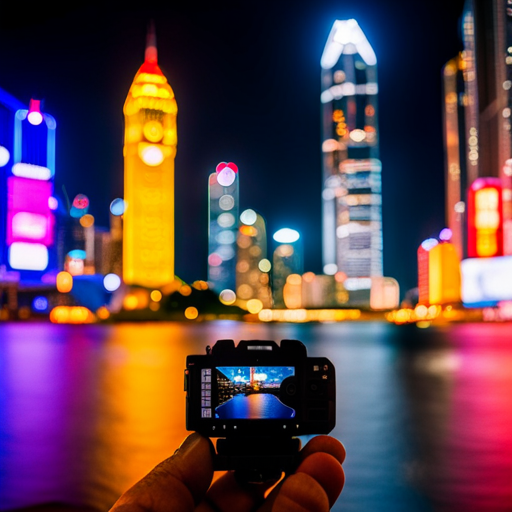

In [32]:
os.makedirs("data", exist_ok=True)
image_1 = Image.open(io.BytesIO(base64.decodebytes(bytes(base_64_img_str, "utf-8"))))
image_1.save("data/image_1.png")
image_1

## Image to Image

Generating images from text is powerful, but in some cases could need many rounds of prompt refinement to get an image "just right".

Rather than starting from scratch with text each time, image-to-image generation lets us modify an existing image to make the specific changes we'd like.

We'll have to pass our initial image in to the API in base64 encoding, so first let's prepare that. You can use either the initial image from the previous section, or a different one if you'd prefer:

In [36]:
def image_to_base64(img) -> str:
    """Convert a PIL Image or local image file path to a base64 string for Amazon Bedrock"""
    if isinstance(img, str):
        if os.path.isfile(img):
            print(f"Reading image from file: {img}")
            with open(img, "rb") as f:
                return base64.b64encode(f.read()).decode("utf-8")
        else:
            raise FileNotFoundError(f"File {img} does not exist")
    elif isinstance(img, Image.Image):
        print("Converting PIL Image to base64 string")
        buffer = io.BytesIO()
        img.save(buffer, format="PNG")
        return base64.b64encode(buffer.getvalue()).decode("utf-8")
    else:
        raise ValueError(f"Expected str (filename) or PIL Image. Got {type(img)}")




### Use the sample image for new image

In [37]:
# Define image_to_image1 as a PIL Image object with your actual image file path)
image_to_image1 = Image.open('image_to_image1.png')

init_image_b64 = image_to_base64(image_to_image1)
print(init_image_b64[:80] + "...")

Converting PIL Image to base64 string
iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAAEAAElEQVR4nHz9y5ZkS44siIlgW5ysrOK6...


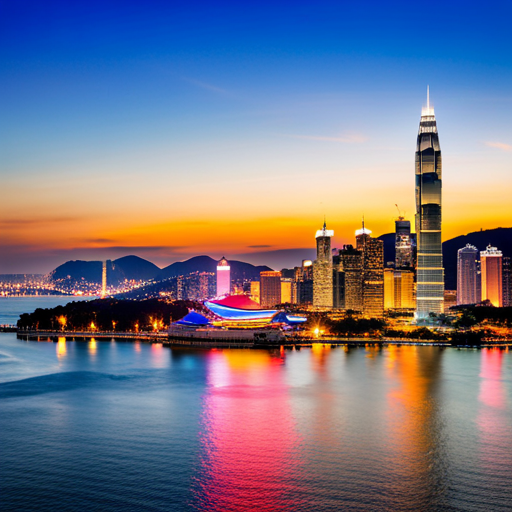

In [38]:
image_to_image1

In [39]:
request = json.dumps({
    "text_prompts": (
        [{"text": prompt, "weight": 1.0}]
        + [{"text": negprompt, "weight": -1.0} for negprompt in negative_prompts]
    ),
    "cfg_scale": 10,
    "init_image": init_image_b64,
    "seed": 3661,
    "start_schedule": 0.6,
    "steps": 150,
    "style_preset": style_preset,
})
modelId = "stability.stable-diffusion-xl-v0"

response = bedrock_client.invoke_model(body=request, modelId=modelId)
response_body = json.loads(response.get("body").read())

print(response_body["result"])
image_2_b64_str = response_body["artifacts"][0].get("base64")
print(f"{image_2_b64_str[0:80]}...")

success
iVBORw0KGgoAAAANSUhEUgAAAgAAAAIACAIAAAB7GkOtAADMXGVYSWZNTQAqAAAACAAGAQAABAAAAAEA...


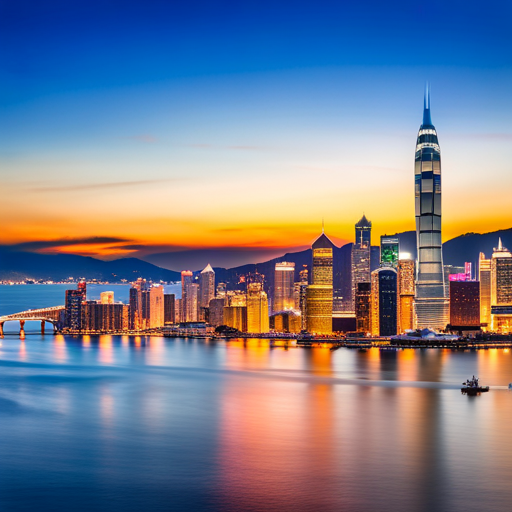

In [40]:
image_2 = Image.open(io.BytesIO(base64.decodebytes(bytes(image_2_b64_str, "utf-8"))))
image_2.save("data/image_2.png")
image_2